In [5]:
import socket, os
import numpy as np
from tensorflow.keras import layers as KL
from tqdm import tqdm
import glob, copy
import scipy
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K

# from freesurfer import deeplearn as fsd
import freesurfer as fs

import neurite as ne
import neurite_sandbox as nes
import voxelmorph as vxm
import voxelmorph_sandbox as vxms
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import surfa as sf
import generators as gens

import layer_dict as ld
import pdb as gdb

import neurite as ne
import neurite_sandbox as nes
import voxelmorph as vxm
import voxelmorph_sandbox as vxms
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import surfa as sf
from utils import *
import argparse
import csv

# parser = argparse.ArgumentParser(description='Process some integers.')
# parser.add_argument('-lr','--learning_rate',type=float, default=0.0001, help="learning rate")
# parser.add_argument('-ie','--initial_epoch',type=int,default=0,help="initial epoch")
# parser.add_argument('-b','--batch_size',default=1,type=int,help="initial epoch")
# parser.add_argument('-n','--num_subnets',default=16,type=int,help="number of subnets")
# parser.add_argument('-e', '--encoder_layers', nargs='+', type=int, help="A list of dimensions for the encoder")
# parser.add_argument('-d', '--decoder_layers', nargs='+', type=int, help="A list of dimensions for the decoder")
# parser.add_argument('-na', '--no_atlas', action='store_true', default=False, help="Custom: Intensities")
# parser.add_argument('-val', '--val', action='store_true', default=False, help="feta")
# parser.add_argument('-dataset', '--dataset', choices=['OASIS','Buckner40', 'FBirn'], default='OASIS')

# args = parser.parse_args()
no_atlas=False
log_dir = "logs/logs_subnets_new"
models_dir = "models_subnets_new"
num_epochs = 2000
num_subnets=64
models_dir="models_subnets_new_64"
dataset = "Buckner40"
if dataset == "OASIS":
    results_dir = 'results/result_oasis_'+str(num_subnets)+'.csv'
elif dataset == "Buckner40":
    results_dir = 'results/result_buckner40_'+str(num_subnets)+'.csv'
elif dataset == "FBirn":
    results_dir = 'results/result_fbirn_'+str(num_subnets)+'.csv'


if dataset == "OASIS":
    print("OASIS loading .. ")

    adir = '/autofs/cluster/freesurfer/subjects/atlases/aseg_atlas'
    mname = 'seg_edited.mgz'
    vname = 'norm.mgz'
    sfile = os.path.join(adir, 'scripts', 'subjects.txt')
    # validation_size=20
    
    with open(sfile, 'r') as f:
        man_subjects = f.read().split('\n')[0:-1]
    # man_subjects=man_subjects[0:validation_size]
elif dataset == "Buckner40":
    print("Buckner40 loading .. ")
    adir = '/autofs/cluster/freesurfer/subjects/test/buckner_data/samseg'
    mname = 'aparc+aseg.mgz'
    vname = 'norm.mgz'
    sfile = os.path.join('/autofs/cluster/freesurfer/subjects/test/buckner_data/subjects.1-33.txt')
    with open(sfile, 'r') as f:
        man_subjects = f.read().split('\n')[0:-1]
elif dataset == "FBirn":
    print("FBirn loading .. ")
    adir = '/autofs/space/bal_004/users/jd1677/datasets/FBirn'
    mname = 'aseg.reg.nii.gz'
    vname = 'norm.reg.nii.gz'
    sfile = os.path.join(adir,'subjects.txt')
    
    with open(sfile, 'r') as f:
        man_subjects = f.read().split('\n')[0:-1]


if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists('results'):
    os.makedirs('results')
weights_saver = PeriodicWeightsSaver(filepath=models_dir, save_freq=10)  # Save weights every 100 epochs

TB_callback = CustomTensorBoard(
    base_log_dir=log_dir,
    models_dir = models_dir,
    histogram_freq=100,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)
import os, shutil, glob

latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
if latest_weight:
    shutil.move(latest_weight, os.path.join(models_dir, 'weights_epoch_0.h5'))
    
initial_epoch=0
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

mse_wt = 1

vscale = 2
vscale = 1

dofit = False
dofit = True

# whether or not to train the synthseg net from scratch with the subnets
combined_training = True
combined_training = False

# whether or not to concat the (extracted) aseg features into the subnets
concat_aseg = False
concat_aseg = True

# have subnets only output the labels that ever occur in their location or all labels
use_lab2ind = True
use_lab2ind = False

# put losses on the individual subnets or not
use_subloss = False
# use_subloss = True

# which optimizer to use
which_opt = 'sgd'
which_opt = 'adam'

# which subnet loss to use (if using a subnet loss)
subloss = 'mse'
subloss = 'dice'

# whether to use the insertion code on the subnet outputs (you always should, wasn't sure at first)
use_insertion = False
use_insertion = True

# whether to freeze the aseg weights when training the subnets
train_aseg = False
train_aseg = True

which_loss = 'both'
which_loss = 'mse'
which_loss = 'cce'
which_loss = 'dice'

same_contrast=False
same_contrast=True

# add synthetic outputs shapes to the images or not
oshapes = False
oshapes = True

# perform linear fitting on inputs to softmax to initialize things
fit_lin = True
fit_lin = False


# do affine augmentation or not
doaff = False
doaff = True


# model_dir = 'models'
gpuid = -1
host = socket.gethostname()
from neurite_sandbox.tf.utils.utils import plot_fit_callback as pfc


print(f'host name {socket.gethostname()}')

# ngpus = 1 if os.getenv('NGPUS') is None else int(os.getenv('NGPUS'))

ngpus =len(os.environ["CUDA_VISIBLE_DEVICES"])
gpu_ids = os.environ.get("CUDA_VISIBLE_DEVICES")

# ngpus =1#len(os.environ["CUDA_VISIBLE_DEVICES"])
# gpu_ids = 0#os.environ.get("CUDA_VISIBLE_DEVICES")

print(f'using {ngpus} gpus')
if ngpus > 1:
    model_device = '/gpu:0'
    synth_device = '/gpu:1'
    synth_gpu  = 1
    val_device=2
    dev_str = "0, 1"
    # dev_str = "0, 1, 2"
    print("dev_str:",dev_str)
else:
    model_device = '/gpu:0'
    synth_device = model_device
    synth_gpu = 0
    dev_str = "0"
    val_device=0

if not dofit and host == 'serena.nmr.mgh.harvard.edu':
    dev_str = '/cpu:0'
    print(f'setting dev_str to {dev_str}')

os.environ["CUDA_VISIBLE_DEVICES"] ="0,1,2,3"

print(f'model_device {model_device}, synth_device {synth_device}, dev_str {dev_str}')

print(f'physical GPU # is {os.getenv("SLURM_STEP_GPUS")}')
ret = ne.utils.setup_device(dev_str)

print(f'dofit {dofit}, doaff {doaff}, fit_lin {fit_lin}, oshapes {oshapes}, subnet loss {use_subloss}, use_lab2ind {use_lab2ind}, combined_training {combined_training}, insertion {use_insertion}, concat aseg {concat_aseg}, subloss {subloss}')


batch_size = 1

odir = '/autofs/vast/braindev/braindev/OASIS/OASIS1/synth-high-res/recon_subject'
subjects = [f for f in Path(odir).iterdir() if 'OASIS_OAS1_0' in str(f)]
# seg_files = [f/f'mri/aparc+aseg.mgz' for f in tqdm(subjects)]
seg_files = [f/f'mri/aseg.mgz' for f in tqdm(subjects)]

if dofit:
    print(f'TRAINING model with loss {which_loss}')
else:
    print(f'loading model trained with {which_loss} loss')

target_shape = (192,)*3
inshape = target_shape


# number of subnets and the size of the input patch to each one
patch_size = 32
num_subnets = num_subnets

initial_epoch =0

pad_size=4
# add some padding to the subnets so that there is always some context for each voxel
big_patch_size = patch_size + 2 * pad_size
phalf = patch_size // 2
bphalf = big_patch_size // 2

print(f'patch_size = {patch_size}, num_subnets = {num_subnets}, pad_size = {pad_size}')

ntest = 25
crop = -1 if dofit else ntest
crop = 20
validation_size=20
crop_indices = np.random.choice(len(seg_files), crop, replace=False)

lut = fs.lookups.default()

lesion_label_orig = lut.search('Left-Lesion')
if len(lesion_label_orig) > 0:
    lesion_label_orig = lesion_label_orig[0]
else:   # not in the lut - add a new one
    lesion_label_orig = 77
    lut.add(lesion_label_orig, 'Lesion', color=[240,240,240])

# if 'inited' not in locals() and 'inited' not in globals():
    # inited = False
inited=False
warp_max = 2
if not inited:

    mri_segs_orig = [sf.load_volume(str(seg_files[i])) for i in tqdm(crop_indices)]


    if vscale > 1:
        print(f'downsampling by {vscale}')
        mri_segs = [mri.reslice(vscale) for mri in tqdm(mri_segs_orig)]
    else:
        print(f'cropping to {target_shape}')
        mri_segs = [mri.fit_to_shape(target_shape, center='bbox') for mri in tqdm(mri_segs_orig)]
        # mri_segs = [mri.reshape(target_shape, center='bbox') for mri in tqdm(mri_segs)]

    np_segs_orig = [mri.data for mri in mri_segs]
    fname = 'npy_malte/oasis_labels.npy'
    if os.path.exists(fname):
        print(f'loading unique labels in {len(mri_segs_orig)} from {fname}')
        labels_orig = np.load(fname)
    else:
        print(f'finding unique labels in {len(mri_segs_orig)} datasets...')
        labels_orig = np.unique(np.array(np_segs_orig))
        np.save(fname, labels_orig)

    ### map csf with bg
    np_segs = [vol.data for vol in mri_segs]
    np_segs_no_csf = []
    for vol in mri_segs:
        vol_copy = np.array(vol)  # Make a copy to avoid modifying the original
        vol_copy[vol_copy == 24] = 0
        np_segs_no_csf.append(vol_copy)
        
    # mapping = fs.lookups.tissue_type_recoder_no_skull(include_lesions=use_lesions)
    mapping = fs.lookups.nonlateral_aseg_recoder()
    target_lut = mapping.target_lut
    lut_name = 'nonlat.txt'
    mri_segs_recoded = [fs.label.recode(mri, mapping) for mri in np_segs_no_csf]  
    lesion_label = target_lut.search('Left-Lesion')[0]
    np_segs = [vol.data for vol in mri_segs_recoded]


        
    labels_in = np.unique(np.array(np_segs)).astype(int)
    if lesion_label not in labels_in:
        l = list(labels_in)
        l.append(lesion_label)
        labels_in = np.array(l)
    nlabels_small = len(labels_in)
    label_map = {}
    keys = mapping.mapping.keys()
    lab_to_ind = np.zeros((labels_orig.max()+1,), dtype=int)
    for label in labels_orig:
        if label not in keys:
            output_label = 0
        else:
            output_label = mapping.mapping[label]
        label_map[label] = output_label
        lab_to_ind[label] = output_label


    import generators as gens
    vxm_model = gens.read_vxm_model(inshape)
    vxm_smooth_wt = np.zeros((1, 1))
    vxm_smooth_wt[0,0] = .3   # warp regularization hyper parameter
    
    gen_model = gens.create_gen_model(np_segs, oshapes, synth_device, nlabels_small, labels_in, inshape, warp_max)

    mapping = fs.lookups.nonlateral_aseg_recoder()
    target_lut = mapping.target_lut
    lut_name = 'nonlat.txt'

    mri_man_segs = []  # manual segs
    mri_norms = []  # mri vols
    mri_norms_orig = []
    mri_man_segs_orig = []
    for s in tqdm(man_subjects):
        mri_seg_orig = sf.load_volume(os.path.join(adir, s, 'mri', mname))

    
        mri_man_segs_orig.append(mri_seg_orig)
        # mri_seg = mri_seg_orig.fit_to_shape(target_shape, center='bbox')
        mri_seg = mri_seg_orig.reshape(target_shape)
        mri_man_segs.append(mri_seg)
        # mri_norm_orig = fs.Volume.read(os.path.join(adir, s, 'mri', vname))
        mri_norm_orig = sf.load_volume(os.path.join(adir, s, 'mri', vname))

        mri_norm = mri_norm_orig.resample_like(mri_seg)
        mri_norms.append(mri_norm)
        mri_norms_orig.append(mri_norm_orig)
        
    mri_man_segs_recoded = [fs.label.recode(mri, mapping) for mri in tqdm(mri_man_segs)]

    # mri_seg_atlas = fs.Volume.read("aseg_atlas.mgz")
    # mri_seg_atlas = sf.load_volume("aseg_atlas.mgz").reshape(target_shape)
    if no_atlas:
        s_moved = np.concatenate(moved, axis=0)
        mri_seg_atlas = sf.Volume(np.mean(s_moved, axis=0))
        mri_seg_atlas.data = unify_left_right(mri_seg_atlas.data)
    else:
        mri_seg_atlas = sf.load_volume("atlas_100_onehot.mgz").reshape(target_shape)
        mri_seg_atlas.data = unify_left_right(mri_seg_atlas.data)

        num_classes = len(np.unique(mri_seg_atlas.data))
        one_hot_data = tf.one_hot(mri_seg_atlas.data, num_classes)
        mri_seg_atlas.data = one_hot_data
    
    hard_seg = np.argmax(mri_seg_atlas.data, axis=-1)
    mri_hard_seg = mri_seg_atlas.copy()
    mri_hard_seg.data = hard_seg
    mri_hard_seg_cropped = mri_hard_seg.reshape(target_shape)
    print(mri_hard_seg_cropped.shape)
    # mri_norm_atlas = sf.load_volume("norm_atlas.mgz").resample_like(mri_hard_seg)
    mri_norm_atlas = sf.load_volume("atlas_100.mgz").resample_like(mri_hard_seg)

    print(mri_norm_atlas.shape)
    # mri_hard_seg = mri_seg_atlas.copy(hard_seg).fit_to_shape(target_shape, center='bbox')
    # mri_norm_atlas = fs.Volume.read("norm_atlas.mgz").resample_like(mri_hard_seg)

    mri_seg_atlas = mri_seg_atlas.resample_like(mri_hard_seg)
    norm_atlas = (mri_norm_atlas.data / mri_norm_atlas.data.max())[np.newaxis, ..., np.newaxis]
    print("norm atlas shape: ", norm_atlas.shape,mri_hard_seg.shape,mri_seg_atlas.shape)
    
    f = 128
    # conf = {
    #     'enc_nf': [f] * 4,
    #     'dec_nf': [f] * 4,
    #     'add_nf': [f] * 4,
    #     'hyp_units': [32] * 4,
    # }
    conf = {
       'def.enc_nf': [f] * 4,
       'def.dec_nf': [f] * 4,
       'def.add_nf': [f] * 4,
       'def.hyp_den': [32] * 4,
    }

    vxm_model = vxms.networks.VxmJointAverage(in_shape=inshape, **conf)
    vxm_model.load_weights(os.path.join('models_from_Malte', f'VxmJointAverage{f}.h5'))
    # vxm_model = vxm.networks.HyperVxmJoint(in_shape=inshape, **conf)
    # vxm_model.load_weights(os.path.join('models_from_Malte', f'hyp_mse_uni_{f}_lm10_mid.h5'))
    #aseg_model = tf.keras.models.load_model('aseg.h5', custom_objects=ld.layer_dict)
    aseg_train_fscale = 1.1
    if 1:
        aseg_train_fname = f'aseg_subnet/aseg.fscale.{aseg_train_fscale}.h5'
        print(f'loading aseg model {aseg_train_fname}')
        aseg_model = tf.keras.models.load_model(aseg_train_fname, 
                                                custom_objects=ld.layer_dict)
    else:
        aseg_model = tf.keras.models.load_model('aseg.h5', custom_objects=ld.layer_dict)

    l = np.zeros((1, 1))
    l[0,0] = .3   # warp regularization hyper parameter

    # psize = (norm_atlas.shape[1] - mri_norms[0].shape[0]) // 2
    # pad = ((0,0), (psize,psize), (psize, psize), (psize, psize), (0, 0))
    # lfunc = ne.losses.Dice(nb_labels=nlabels_small, weights=None, check_input_limits=False).mean_loss
    lfunc = nes.losses.DiceNonzero(nlabels_small, weights=None, check_input_limits=False).loss
    # read_cached = False
    read_cached = False
    new_cache = True  # fscale specific
    if not read_cached:
        dice_list = []
        elist = []
        elist_in_atlas = []
        alist_in_atlas = []
        nlist_in_atlas = []
        mlist_in_atlas = []
        for sno, s in enumerate(tqdm(subjects)):
            mseg_onehot = np.eye(nlabels_small)[mri_man_segs_recoded[sno].data]
            norm = (mri_norms[sno].data / mri_norms[sno].data.max())[np.newaxis, ..., np.newaxis]
            pred = aseg_model.predict(norm)
            transform = vxm_model.predict([l, norm, norm_atlas])
            # transform = transform[:, psize:-psize, psize:-psize, psize:-psize, :]
            dice = lfunc(tf.convert_to_tensor(mseg_onehot[np.newaxis], tf.float32), 
                         tf.convert_to_tensor(pred, tf.float32))
            dice_list.append(dice.numpy())
            ev = (mseg_onehot - pred[0])
            evol = (ev**2).sum(axis=-1)
            elist.append(evol)
            evol_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([evol[np.newaxis, ..., np.newaxis], transform])
            norm_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([norm, transform])
            aseg_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([pred[0][np.newaxis, ...], transform])
            mseg_in_atlas = vxm.layers.SpatialTransformer(interp_method='linear', fill_value=0)([mseg_onehot[np.newaxis, ...], transform])
            elist_in_atlas.append(evol_in_atlas.numpy().squeeze())
            nlist_in_atlas.append(norm_in_atlas.numpy().squeeze())
            #alist_in_atlas.append(np.argmax(aseg_in_atlas.numpy(), axis=-1).squeeze())
            #mlist_in_atlas.append(np.argmax(mseg_in_atlas.numpy(), axis=-1).squeeze())
            alist_in_atlas.append(aseg_in_atlas.numpy().squeeze())
            mlist_in_atlas.append(mseg_in_atlas.numpy().squeeze())

        np.save(f'npy_malte/elist_in_atlas.fscale.{aseg_train_fscale}.npy', elist_in_atlas)
        np.save(f'npy_malte/nlist_in_atlas.fscale.{aseg_train_fscale}.npy', nlist_in_atlas)
        np.save(f'npy_malte/alist_in_atlas.fscale.{aseg_train_fscale}.npy', alist_in_atlas)

        print('computing index occurence volumes')
        aseg_inds = np.argmax(np.array(alist_in_atlas), axis=-1)
        mseg_inds = np.argmax(np.array(mlist_in_atlas), axis=-1)
        max_inds = nlabels_small
        mseg_ind_vol = np.zeros(target_shape + (max_inds,))
        aseg_ind_vol = np.zeros(target_shape + (max_inds,))
        mseg_num_inds = np.zeros(target_shape)
        aseg_num_inds = np.zeros(target_shape)
        for x in tqdm(range(aseg_inds.shape[1])):
            for y in range(aseg_inds.shape[2]):
                for z in range(aseg_inds.shape[3]):
                    ind_list = -1 * np.ones((max_inds,))
                    u = np.unique(mseg_inds[:, x, y, z])
                    for lno, l in enumerate(u):
                        if lno >= max_inds:
                            break
                            mseg_ind_vol[x, y, z, lno] = l
                
                    mseg_num_inds[x, y, z] = len(u)
                    ind_list = -1 * np.ones((max_inds,))
                    u = np.unique(aseg_inds[:, x, y, z])
                    for lno, l in enumerate(u):
                        aseg_ind_vol[x, y, z, lno] = l

                    aseg_num_inds[x, y, z] = len(u)

        inds_trivial = np.nonzero(mseg_num_inds < 2)
        evol_avg = np.array(elist_in_atlas).mean(axis=0)
        evol_avg[inds_trivial] = 0
        nvol_avg = np.array(nlist_in_atlas).mean(axis=0)
        low_val = 0 if num_subnets == 20 else -1000
        nbhd_img_orig = scipy.ndimage.convolve(evol_avg, np.ones((patch_size,)*3)/(patch_size**3), 
                                               mode='constant',  cval=low_val)
        np.save(f'npy_malte/nbhd_img.fscale.{aseg_train_fscale}.npy', nbhd_img_orig)
        np.save(f'npy_malte/evol_avg.fscale.{aseg_train_fscale}.npy', evol_avg)
        np.save(f'npy_malte/nvol_avg.fscale.{aseg_train_fscale}.npy', nvol_avg)
    else:   # not dofit
        if new_cache:
            print(f'reading cached volumes scale {aseg_train_fscale}')
            nbhd_img_orig = np.load('npy_malte/nbhd_img.npy', allow_pickle=True)
            elist_in_atlas = np.load(f'npy_malte/elist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            nlist_in_atlas = np.load(f'npy_malte/nlist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True) 
            alist_in_atlas = np.load(f'npy_malte/alist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            mlist_in_atlas = np.load(f'npy_malte/mlist_in_atlas.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            evol_avg = np.load(f'npy_malte/evol_avg.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
            nvol_avg = np.load(f'npy_malte/nvol_avg.fscale.{aseg_train_fscale}.npy', allow_pickle=True)
        else:
            print('reading cached volumes')
            nbhd_img_orig = np.load('npy_malte/nbhd_img.npy', allow_pickle=True)
            elist_in_atlas = np.load('npy_malte/elist_in_atlas.npy', allow_pickle=True)
            nlist_in_atlas = np.load('npy_malte/nlist_in_atlas.npy', allow_pickle=True)
            alist_in_atlas = np.load('npy_malte/alist_in_atlas.npy', allow_pickle=True)
            mlist_in_atlas = np.load('npy_malte/mlist_in_atlas.npy', allow_pickle=True)
            evol_avg = np.load('npy_malte/evol_avg.npy', allow_pickle=True)
            nvol_avg = np.load('npy_malte/nvol_avg.npy', allow_pickle=True)

    inited = True



Buckner40 loading .. 
host name rtx-08.nmr.mgh.harvard.edu
using 1 gpus
model_device /gpu:0, synth_device /gpu:0, dev_str 0
physical GPU # is None
dofit True, doaff True, fit_lin False, oshapes True, subnet loss False, use_lab2ind False, combined_training False, insertion True, concat aseg True, subloss dice


100%|██████████| 415/415 [00:00<00:00, 163562.88it/s]


TRAINING model with loss dice
patch_size = 32, num_subnets = 64, pad_size = 4


100%|██████████| 20/20 [00:01<00:00, 19.14it/s]


cropping to (192, 192, 192)


100%|██████████| 20/20 [00:00<00:00, 158.88it/s]


loading unique labels in 20 from npy_malte/oasis_labels.npy
using warp max = 2 and nlabels 17


(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(96, 96, 96, 3)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
Tensor("perlin_noise_3/strided_slice:0", shape=(4,), dtype=int32)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(96, 96, 96, 3)
Tensor("model_29/perlin_noise_3/strided_slice:0", shape=(4,), dtype=int32)


100%|██████████| 33/33 [02:25<00:00,  4.41s/it]


(192, 192, 192)
(192, 192, 192)
norm atlas shape:  (1, 192, 192, 192, 1) (192, 192, 192) (192, 192, 192, 19)
loading aseg model aseg_subnet/aseg.fscale.1.1.h5


  0%|          | 0/415 [00:00<?, ?it/s]2024-08-09 11:48:27.608011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 106s 106s/step


2024-08-09 11:50:12.806672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
  0%|          | 0/415 [01:46<?, ?it/s]


KeyboardInterrupt: 

In [10]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
volume = np.load('npy_malte/nbhd_img.npy', allow_pickle=True)
new_image = nib.Nifti1Image(volume, affine=np.eye(4))
print(new_image.ndim)
nib.save(nib.Nifti1Image(volume, affine=np.eye(4)), f"nbhd_img.nii.gz")
# ne.plot.volume3D(new_image)
# num_slices = volume.shape[2]  # Assuming the 3rd dimension is the slice dimension
# slice_index = num_slices // 2
# plt.imshow(volume[slice_index, :, :], cmap='gray')
# plt.colorbar()
# plt.title('Middle Slice of 3D Volume')
# plt.show()

3


In [ ]:

nbhd_img = nbhd_img_orig.copy()
mseg_avg = np.argmax(np.array(mlist_in_atlas).mean(axis=0), axis=-1)
aseg_avg = np.argmax(np.array(alist_in_atlas).mean(axis=0), axis=-1)
    
mlist_ind = np.argmax(np.array(mlist_in_atlas), axis=-1)
alist_ind = np.argmax(np.array(alist_in_atlas), axis=-1)

if dofit:    #  run training
    patch_labels = []
    patch_centers = []
    for netno in range(num_subnets):
        max_ind = np.argmax(nbhd_img[bphalf:-bphalf, bphalf:-bphalf, bphalf:-bphalf])
        patch_center = np.unravel_index(max_ind, nbhd_img[bphalf:-bphalf, bphalf:-bphalf, bphalf:-bphalf].shape) + np.array([bphalf, bphalf, bphalf])
        # should use bphalf here
        x0 = patch_center[0]-patch_size//2
        x1 = x0 + patch_size 
        y0 = patch_center[1]-patch_size//2
        y1 = y0 + patch_size 
        z0 = patch_center[2]-patch_size//2
        z1 = z0 + patch_size
        labels_mseg = np.unique(mlist_ind[:, x0:x1, y0:y1, z0:z1])
        labels_aseg = np.unique(alist_ind[:, x0:x1, y0:y1, z0:z1])
        print(f'patch at {patch_center}: labels {labels_mseg}')
        patch_centers.append(patch_center)
        bx0 = patch_center[0]-big_patch_size//2
        bx1 = x0 + big_patch_size 
        by0 = patch_center[1]-big_patch_size//2
        by1 = y0 + big_patch_size 
        bz0 = patch_center[2]-big_patch_size//2
        bz1 = z0 + big_patch_size
        nbhd_img[bx0:bx1, by0:by1, bz0:bz1] = -1000  # prevent overlap of subsequent patches
        print("patch label shape:",labels_mseg.shape)
        patch_labels.append(labels_mseg)

    print('saving patch centers and labels...')
    np.savez(f'npy_malte/patch_labels.{patch_size}.{num_subnets}.{pad_size}.npy', *patch_labels)
    np.save(f'npy_malte/patch_centers.{patch_size}.{num_subnets}.{pad_size}.npy', patch_centers)
else:
    print('loading patch centers and labels...')
    patch_labels_files = np.load(f'npy_malte/patch_labels.{patch_size}.{num_subnets}.{pad_size}.npy', allow_pickle=True)
    patch_labels = [patch_labels_files[key] for key in patch_labels_files.files]

    patch_centers = np.load(f'npy_malte/patch_centers.{patch_size}.{num_subnets}.{pad_size}.npy', allow_pickle=True)


if combined_training:   # train synthseg net and subnets from scratch
    nfeats = 64
    unet_nf = []
    nb_conv_per_level = 2
    fscale = 1
    fscale = 1.1
    nb_levels = int(np.log2(inshape[0]))-(1)   # 4,4,4 is lowest level

    for level in range(nb_levels):
        filters_in_this_level = []
        for layer in range(nb_conv_per_level):
            filters_in_this_level.append(int(fscale**level*nfeats))
        
        unet_nf.append(filters_in_this_level)

    model_lin = ne.models.unet(unet_nf, inshape+(1,), None, 3, nlabels_small, feat_mult=None, final_pred_activation='linear')
    softmax_out = KL.Softmax(name='seg')(model_lin.outputs[0])
    aseg_model = tf.keras.Model(model_lin.inputs, [softmax_out])
else:
    aseg_train_fname = f'aseg_subnet/aseg.fscale.{aseg_train_fscale}.h5'
    print(f'loading aseg model {aseg_train_fname}')
    aseg_model = tf.keras.models.load_model(aseg_train_fname, custom_objects=ld.layer_dict)

# find last feature layer of the aseg unet
for lno in range(len(aseg_model.layers)-1, 0, -1):
    aseg_layer = aseg_model.layers[lno]
    if aseg_layer.name.startswith("unet_conv_uparm"):
        break

nfeats = aseg_layer.output[0].get_shape().as_list()[-1]


gen_model = gens.create_gen_model(mri_segs_recoded, oshapes, synth_device, nlabels_small, labels_in, inshape)

# generate a  synth image
# inputs are synth images
# outputs are label maps
# build lists for unet architecture
nb_levels = int(np.log2(patch_size))-1
nb_levels = int(np.log2(big_patch_size))-1
nb_conv_per_level = 2
unet_scale = 1
    
unet_nf = []
fscale = 1.1
fscale = 1


for level in range(nb_levels):
    filters_in_this_level = []
    for layer in range(nb_conv_per_level):
        filters_in_this_level.append(int(fscale**level*nfeats))
        
    unet_nf.append(filters_in_this_level)


tf.compat.v1.enable_eager_execution()

lr = 1e-5
lr = 1e-4
name = f'subnets.outside.unet_nf.{nfeats}.warp_max.{warp_max}.oshapes.{oshapes}.num_subnets.{num_subnets}.psize.{patch_size}.pad.{pad_size}.lab2ind.{use_lab2ind}.lr.{lr}.subloss.{use_subloss}.insertion.{use_insertion}.combined_training.{combined_training}.train_aseg.{train_aseg}'
if not concat_aseg:
    name += f'.concat_aseg.{concat_aseg}'
if use_subloss and subloss != 'dice':
    name += f'.subloss.{subloss}'
if which_opt != 'adam':
    name += f'.which_opt.{which_opt}'



label_weights = np.ones((1,nlabels_small,))
# label_weights[0,-1] = .01  # downweight lesion class
lfunc = ne.losses.Dice(nb_labels=nlabels_small, weights=None, check_input_limits=False).mean_loss
lfunc = nes.losses.DiceNonzero(nlabels_small, weights=None, check_input_limits=False).loss
if use_subloss:
    if subloss == 'dice':
        thresh = -.2*3
    else:
        thresh = 8
else:
        thresh = -.2*2
    

cooldown = 25
patience = 600

# write_cb_lin = nes.callbacks.WriteHist(name+'.lin.txt')

losses = [lfunc]
loss_weights = [1]
if use_subloss:
    if subloss == 'mse':
        lfunc_subnet = lambda a, b: mse_wt * tf.keras.losses.MSE(a, b)
    else:
        lfunc_subnet = lfunc
    #lfunc_mse = tf.keras.losses.mse
    losses += [lfunc_subnet]
    loss_weights += [1]


unet_device = model_device if (fit_lin or dofit) else synth_device
with tf.device(unet_device):     # add the subnets to the big unet
    aseg_shape = aseg_layer.output.get_shape().as_list()[1:]
    aseg_linear_out = aseg_model.layers[-3].output  # tensor right before outputs compressed to nlabels

    subnet_outputs_to_add = [aseg_linear_out]  # add subnet outputs to this tensor for final output
    subnet_outputs = []  # list of subnet outputs each nlabels_small long (only for using subloss)
    subnet_patches = []  # spatial location of the subnet patches
    pre_lab2ind = []

    for subnet_no in range(num_subnets):
        bx0 = patch_centers[subnet_no][0]-big_patch_size//2
        bx1 = bx0 + big_patch_size 
        by0 = patch_centers[subnet_no][1]-big_patch_size//2
        by1 = by0 + big_patch_size 
        bz0 = patch_centers[subnet_no][2]-big_patch_size//2
        bz1 = bz0 + big_patch_size 
        # only inner part without padding
        x0 = patch_centers[subnet_no][0]-patch_size//2
        x1 = x0 + patch_size 
        y0 = patch_centers[subnet_no][1]-patch_size//2
        y1 = y0 + patch_size 
        z0 = patch_centers[subnet_no][2]-patch_size//2
        z1 = z0 + patch_size 
        # labels_mseg = np.unique(mlist_ind[:, bx0:bx1, by0:by1, bz0:bz1])
        labels_mseg = np.unique(mlist_ind[:, x0:x1, y0:y1, z0:z1])
        noutputs = len(labels_mseg) if use_lab2ind else nlabels_small

        # extract a patch of (1) the data on the uparm of the big net and (2) the input volume
        aseg_patch = nes.layers.ExtractPatch(((bx0, bx1), (by0, by1), (bz0, bz1)), 
                                             name=f'aseg_patch{subnet_no}')(aseg_layer.output)
        patch_input = nes.layers.ExtractPatch(((bx0, bx1), (by0, by1), (bz0, bz1)),
                                              name=f'subnet_input{subnet_no}')(aseg_model.inputs[0])
        nf = aseg_patch.get_shape().as_list()[-1]
        print("unet, big_patch_size, noutputs: ",unet_nf,big_patch_size,noutputs)
        subnet_lin = ne.models.unet(unet_nf, (big_patch_size,)*3+(1,), None, 3, noutputs, feat_mult=None, final_pred_activation='linear', name=f'subnet{subnet_no}')

        if use_lab2ind:
            # concat aseg_model info to second-to-last layer of subnet
            if concat_aseg:
                tmp_model = tf.keras.Model(subnet_lin.inputs, subnet_lin.layers[-3].output)
                tmp_out = tmp_model(patch_input)
                unet_concat = KL.Concatenate(name=f'subnet_in{subnet_no}', axis=-1)([tmp_out, aseg_patch])
                Conv = getattr(KL, 'Conv%dD' % 3)
                subnet_out = Conv(noutputs, 3, strides=1, padding='same')(unet_concat)
            else:
                subnet_out = subnet_lin(patch_input)
            
            pre_lab2ind.append(subnet_out)
            unet_out = nes.layers.IndexToLabel(labels_mseg, nlabels_small, name=f'IndToLab{subnet_no}')(subnet_out)
        else:  # what about concatting in the non lab2ind case????
            unet_out = subnet_lin(patch_input)

        # crop out the beginning and ending pad regions so output is just central patch_size
        p0 = pad_size
        p1 = pad_size+patch_size
        patch_output = nes.layers.ExtractPatch(((p0, p1), (p0, p1), (p0, p1)),
                                               name=f'subnet_output{subnet_no}')(unet_out)

        if use_subloss:
            if subloss == 'dice':
                subnet_softmax = KL.Softmax(name=f'subnet{subnet_no}_softmax')(patch_output)
                subnet_outputs.append(subnet_softmax[:, tf.newaxis, ...])
            else:   # just include the linear output for mse loss
                subnet_outputs.append(patch_output[:, tf.newaxis, ...])

            subnet_patches.append(((x0, x1), (y0, y1), (z0, z1)))

        if subnet_no == 0 or not use_insertion:
            # padding = ((x0, aseg_shape[0]-x1), (y0, aseg_shape[1]-y1), (z0, aseg_shape[2]-z1))
            # padded_unet_output = nes.layers.Pad(padding=padding, mode='constant', name=f'pad_subnet{subnet_no}')(patch_output)
            from keras.layers import ZeroPadding3D

            # Assuming 'patch_output' is a Keras tensor
            padding = ((x0, aseg_shape[0] - x1), (y0, aseg_shape[1] - y1), (z0, aseg_shape[2] - z1))
            padded_unet_output = ZeroPadding3D(padding=padding, name=f'pad_subnet{subnet_no}')(patch_output)

            if not use_insertion:
                subnet_outputs_to_add.append(padded_unet_output)
            else:   # initialize one big tensor with patch outputs
                big_patches_output = padded_unet_output
        else:  # just insert this patch (since they don't overlap don't need to add)
            offset = ((x0, y0, z0, 0))
            big_patches_output = nes.layers.InsertPatch(big_patches_output, offset, 
                                                         name=f'patch_insert{subnet_no}')([
                                                             patch_output, big_patches_output])
            

    if not use_insertion:
        summed_aseg_outputs = KL.Add(name='patch_plus_unet')(subnet_outputs_to_add)
    else:
        summed_patch_outputs = KL.Lambda(lambda x: x, name='summed_patch_outputs')(big_patches_output)
        summed_aseg_outputs = KL.Add(name='patch_plus_unet')([summed_patch_outputs, aseg_linear_out])

    #Conv = getattr(KL, 'Conv%dD' % 3)
    #linear_out = Conv(nlabels_small, 3, strides=1, padding='same')(summed_aseg_outputs)

    model_lin = tf.keras.Model(aseg_model.inputs, [summed_aseg_outputs])
    softmax_out = KL.Softmax(name='seg')(summed_aseg_outputs)
    outputs = [softmax_out]
    if use_subloss:
        subnet_out = KL.Concatenate(name='subloss', axis=1)(subnet_outputs)
        outputs += [subnet_out]
    model = tf.keras.Model(aseg_model.inputs, outputs)


# create the training (synth) and validation (on real data) generators
with tf.device(synth_device):
    val_size = 20
    gen = gens.synth_gen(mri_segs_recoded, gen_model, vxm_model, norm_atlas, 
                         None, labels_in, 
                         batch_size=batch_size, 
                         subnet_patches=subnet_patches if use_subloss else None,
                         use_log_for_subnet=subloss == 'mse',
                         use_rand=True, gpuid=synth_gpu, debug=False, add_outside=oshapes)
    vgen = gens.real_gen(mri_man_segs_recoded, mri_norms, vxm_model, norm_atlas, 
                         None, labels_in, 
                         batch_size=batch_size, use_rand=True,
                         use_log_for_subnet=subloss == 'mse',
                         subnet_patches=subnet_patches if use_subloss else None,
                         gpuid=val_device, debug=False, add_outside=oshapes)



# set this to nonzero if restarting training from an interrupted run
initial_epoch = 1
initial_epoch = 0

if not use_subloss:
    key_replacements = {
        'loss' : 'seg_loss',
        'val_loss' : 'val_seg_loss'
    }
else:
    key_replacements = None


opt = keras.optimizers.Adam(learning_rate=lr) if which_opt == 'adam' else keras.optimizers.SGD(learning_rate=lr)
nes.utils.check_and_compile(model, gen, optimizer=opt, 
                            loss=losses, loss_weights=loss_weights, check_layers=False, run_eagerly=True)

callbacks = [TB_callback,weights_saver]
checkpoint = tf.train.Checkpoint(model=model,optim=model.optimizer)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, f'{name}.saved_model', max_to_keep = 5)
cp = checkpoint_manager.restore_or_initialize()
if initial_epoch > 0:
    status = checkpoint.restore(checkpoint_manager.latest_checkpoint)




[  0   2   3   4   5   7   8  10  11  12  13  14  15  16  17  18  26  28
  30  31  41  42  43  44  46  47  49  50  51  52  53  54  58  60  62  63
  72  77  80  85 251 252 253 254 255] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


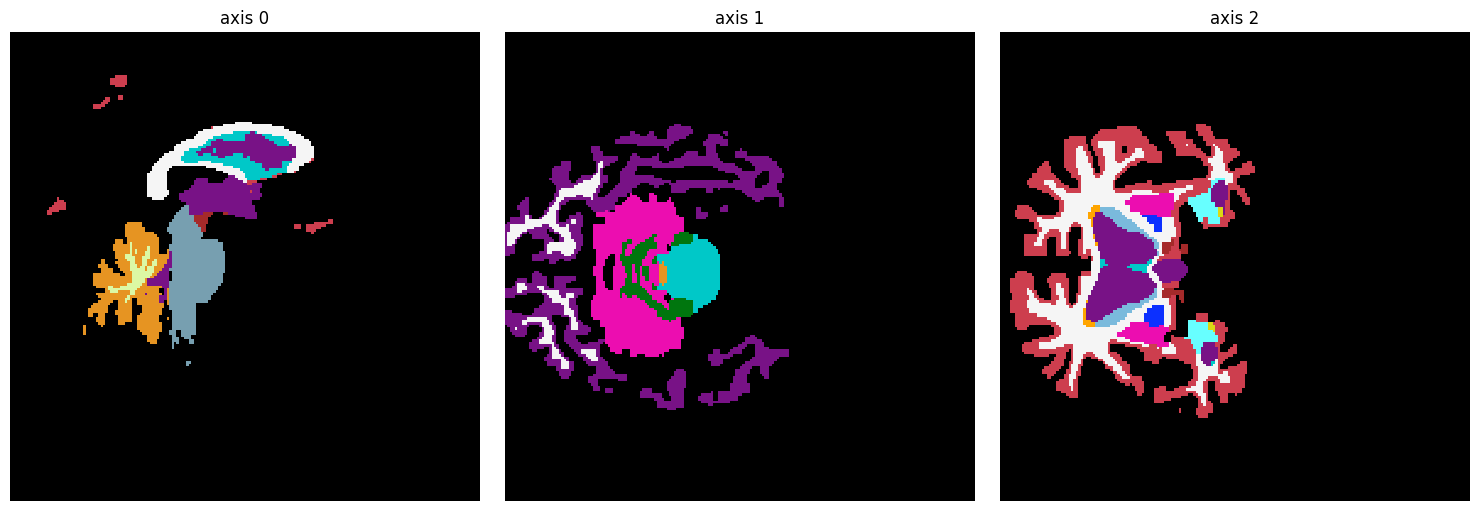

In [156]:
# mapping = fs.lookups.nonlateral_aseg_recoder()
# target_lut = mapping.target_lut
# print(np.unique(mri_segs))
fs_cmap, fs_norm = make_cmap('nonlat.txt') 
print(np.unique(np_segs_no_csf[0]),np.unique(mri_segs_recoded[0]))
# ne.plot.volume3D(np_segs_no_csf[0], cmaps=[fs_cmap])
ne.plot.volume3D(mri_segs_recoded[0], cmaps=[fs_cmap])
# nib.save(nib.Nifti1Image(np_segs_no_csf[0].astype(np.int32), np.eye(4), header=None), f"nocsf.nii.gz")
nib.save(nib.Nifti1Image(mri_segs_recoded[0].astype(np.int32), np.eye(4), header=None), f"csf.nii.gz")

In [108]:
label_ids = {
    "Unknown": 0,
    "Left-Cerebral-White-Matter": 1,
    "Left-Cerebral-Cortex": 2,
    "CSF" :3,
    "Left-Cerebellum-White-Matter": 4,
    "Left-Cerebellum-Cortex": 5,
    "Left-Thalamus": 6,
    "Left-Caudate": 7,
    "Left-Putamen": 8,
    "Left-Pallidum": 9,
    "Brain-Stem": 10,
    "Left-Hippocampus": 11,
    "Left-VentralDC": 15
}

val=True
dice_scores_by_label = {label_name: [] for label_name in label_ids.keys()}


with tf.device(model_device):
    if not train_aseg:
        aseg_model.trainable = False
        
    # print(f"{'saving' if dofit else 'loading'} fit results to {lr_cb.fname} and hist to {write_cb.fname}")
    if dofit:

        if os.path.exists(checkpoint_path):
            model.load_weights(checkpoint_path)
        else:

            print("Checkpoint file not found.")


        if val:
            val_writer = tf.summary.create_file_writer(log_dir)


            csv_file_path = os.path.join(results_dir)
            if not os.path.exists(csv_file_path):
                with open(csv_file_path, 'w', newline='') as csvfile:
                    csv_writer = csv.writer(csvfile)
                    # Write header
                    header = ['Step', 'Overall'] + list(label_ids.keys())
                    csv_writer.writerow(header)
                    print("header created")
    
            num_gen = 10
            step = 0
            with val_writer.as_default():
                while True:
                    # Get the latest weight
                    print("loading weights .. ")
                    latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
                    checkpoint_path = latest_weight
                    model.load_weights(latest_weight)
                    # model.load_weights("models_subnets_new_32/weights_epoch_990.h5")
                    
                    # Generate and predict data
                    inb = sf.load_volume(f"inb-64.nii.gz")
                    t = sf.load_volume(f"t-64.nii.gz")
                    # p = sf.load_volume(f"output/pseg2.nii.gz")
    
                    # inb, outb = next(vgen)
                    p = model.predict(inb[None,...,None])
            
                    # Process prediction and ground truth
                    
                    p = np.argmax(p[0].squeeze(), axis=-1)
                    # t = np.argmax(outb[0].squeeze(), axis=-1)
            
                    p = p.astype(np.int32)
                    t = t.astype(np.int32)
                    overall_dice_score = my_overall_dice(t, p, label_ids)
                    print(p.shape,t.shape,"**********",np.unique(p),np.unique(t),my_nonzero_hard_dice(t,p),overall_dice_score)

                    # Calculate dice scores for each label
                    dice_scores = {}
                    for label_name in label_ids.keys():
                        p_label = np.where(p == label_ids[label_name], 1, 0)
                        t_label = np.where(t == label_ids[label_name], 1, 0)
                        dice_score = my_nonzero_hard_dice(t_label, p_label)
                        dice_scores[label_name] = dice_score
        
                    # Log the Dice scores for each iteration
                    row = [step, overall_dice_score] + [dice_scores[label_name] for label_name in label_ids.keys()]
                    with open(csv_file_path, 'a', newline='') as csvfile:
                        csv_writer = csv.writer(csvfile)
                        csv_writer.writerow(row)
                        
            
                    # Log the Dice score for each iteration
                    tf.summary.scalar('Dice Score', dice_score, step=step)
                    step += 1
                    val_writer.flush()
                    break
                    
                
            
            # Close the writer after logging is complete (optional, depending on your loop condition)
            val_writer.close()
                    
        else:
            fhist = model.fit(gen, epochs=int(num_epochs), steps_per_epoch=10, 
                      initial_epoch=initial_epoch, callbacks=callbacks)
        

loading weights .. 
1/1 [==============================] - 2s 2s/step
(192, 192, 192) (192, 192, 192) ********** [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 0.42581953468723077 0.5418297886633218


In [110]:
inb.shape

(192, 192, 192)

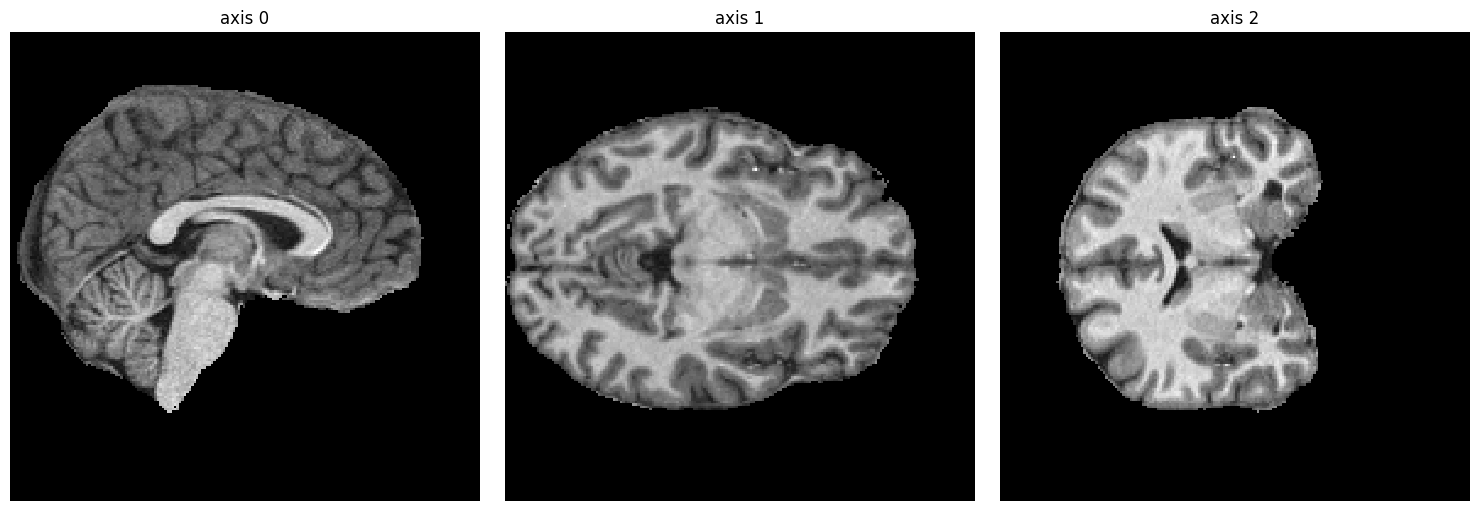

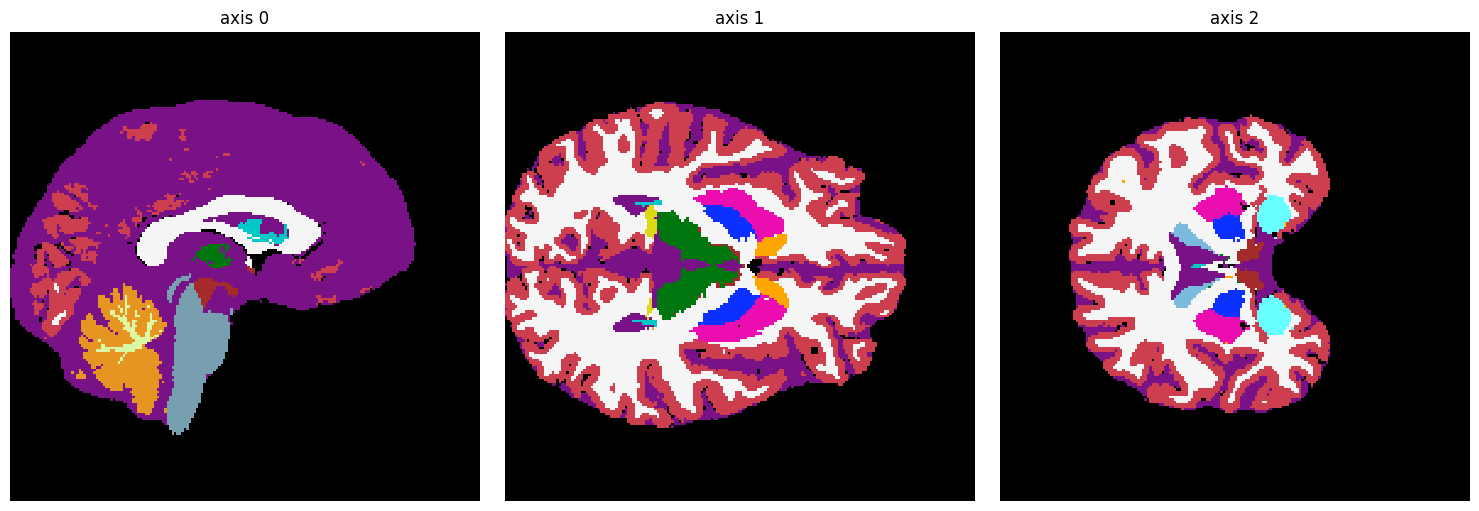

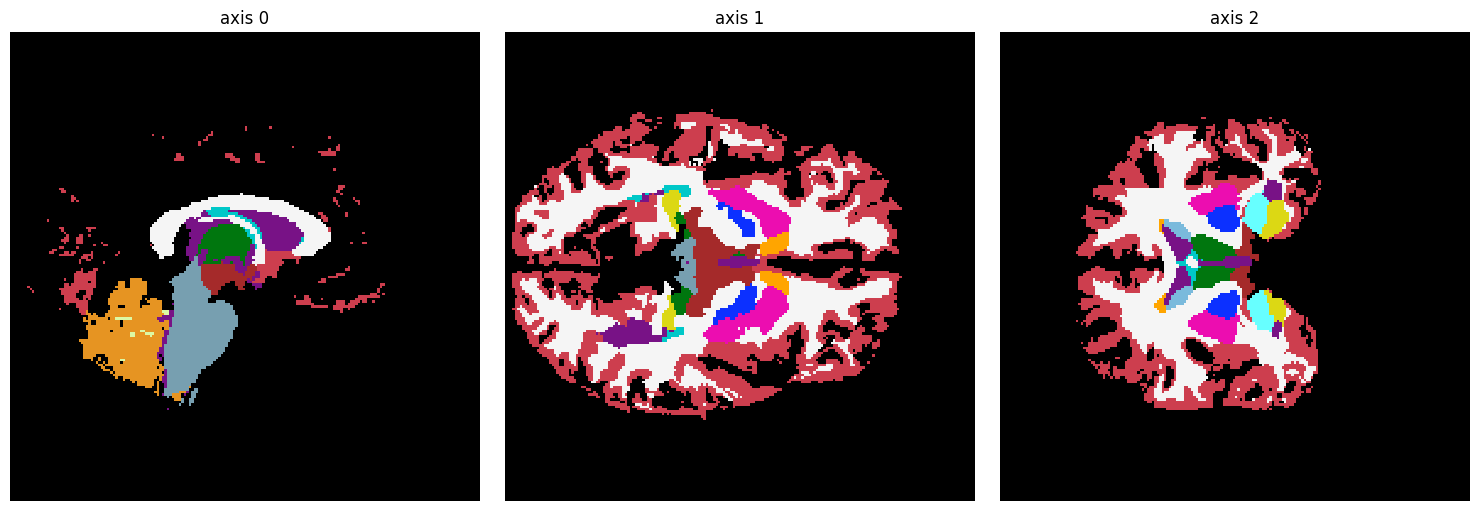

In [109]:
import nibabel as nib

# vgen = real_gen(mri_man_segs_recoded, mri_norms, vxm_model, norm_atlas, 
#                      None, labels_in, 
#                      batch_size=batch_size, use_rand=True,
#                      use_log_for_subnet=subloss == 'mse',
#                      subnet_patches=subnet_patches if use_subloss else None,
#                      gpuid=val_device, debug=False, add_outside=oshapes)
fs_cmap, fs_norm = make_cmap('nonlat.txt') 
# inb, outb = next(vgen)

# p = model.predict(inb[0])
# p =np.argmax(p,axis=-1)
# print(p.shape)
# inb = sf.load_volume(f"output/image1.nii.gz")
ne.plot.volume3D(inb)
ne.plot.volume3D(t, cmaps=[fs_cmap])

ne.plot.volume3D(p, cmaps=[fs_cmap])

# nib.save(nib.Nifti1Image(inb[0][0,...,0], np.eye(4), header=None), f"inb-64.nii.gz")
nib.save(nib.Nifti1Image(t.astype(np.int32), np.eye(4), header=None), f"t-64.nii.gz")
nib.save(nib.Nifti1Image(p.astype(np.int32), np.eye(4), header=None), f"p-64.nii.gz")



In [44]:
print(inb[0].shape)

(1, 192, 192, 192, 1)


In [ ]:
# a = sf.load_volume("/autofs/space/bal_004/users/jd1677/datasets/OASIS/atlas_022.mgz")
from pathlib import Path
from tqdm import tqdm
import surfa as sf
import neurite as ne
import neurite_sandbox as nes
import voxelmorph as vxm
import voxelmorph_sandbox as vxms
import re
from utils import *

def extract_number(path):
    match = re.search(r'OAS1_(\d+)_MR1', str(path))
    if match:
        return int(match.group(1))
    return float('inf')  # Return infinity if no match found


def to_one_hot(seg_vol, num_classes):
    seg_one_hot = np.zeros(seg_vol.shape + (num_classes,), dtype=np.float32)
    for i in range(num_classes):
        seg_one_hot[..., i] = (seg_vol == i).astype(np.float32)
    return seg_one_hot
    
odir = '/autofs/vast/braindev/braindev/OASIS/OASIS1/synth-high-res/recon_subject'
subjects = [f for f in Path(odir).iterdir() if 'OASIS_OAS1_0' in str(f)]
seg_files = [f/f'mri/aseg.mgz' for f in tqdm(subjects)]

trandir='/autofs/space/bal_004/users/jd1677/datasets/OASIS/data'
subjects2= [f for f in Path(trandir).iterdir() if 'OASIS_OAS1_0' in str(f)]
trans_files = []
for subject_folder in tqdm(subjects2):
    transform_file = subject_folder / 'mri' / 'transform.mgz'
    if transform_file.exists():
        trans_files.append(transform_file)
        
# trans_files = [f/f'mri/transform.mgz' for f in tqdm(subjects2)]

trans_files = sorted(trans_files, key=extract_number)

seg_numbers = {extract_number(path) for path in seg_files}
trans_numbers = {extract_number(path) for path in trans_files}
common_numbers = seg_numbers.intersection(trans_numbers)
crop=400
target_shape=[192,192,192]
seg_files = [path for path in seg_files if extract_number(path) in common_numbers]
trans_files = [path for path in trans_files if extract_number(path) in common_numbers]

mri_segs_orig = [sf.load_volume(str(fname)) for fname in seg_files[:crop]]
trans_orig = [sf.load_volume(str(fname)) for fname in trans_files[:crop]]

mri_segs = [mri.fit_to_shape(target_shape, center='bbox') for mri in tqdm(mri_segs_orig)]

for i in range(len(mri_segs)):
    mri_segs[i].data = unify_left_right(mri_segs[i].data.astype(np.float32))

num_classes = len(np.unique(mri_segs))

mri_segs_one_hot = list([to_one_hot(seg_vol, num_classes) for seg_vol in tqdm(mri_segs)])

layer = vxm.layers.SpatialTransformer
moved = [layer(fill_value=0)((f[None,...], t[None,...])) for f, t in zip(mri_segs_one_hot, trans_orig)]

# trans_files = [t.replace("/autofs/vast/braindev/braindev/OASIS/OASIS1/synth-high-res/recon_subject/", "/autofs/space/bal_004/users/jd1677/datasets/OASIS/data") for str(t) in seg_files]
print(moved[0].shape)
# print(trans_files[122])
# print(seg_files[122])
s_moved = np.concatenate(moved, axis=0)
mri_seg_atlas = sf.Volume(np.mean(s_moved, axis=0))
mri_seg_atlas.data = unify_left_right(mri_seg_atlas.data)

hard_seg = np.argmax(mri_seg_atlas.data, axis=-1).astype(np.int32)
nib.save(nib.Nifti1Image(hard_seg, np.eye(4)), f"atlas_1h.nii.gz")

# a=sf.load_volume(str(transforms[0]))
# print(a.shape)
# a=sf.load_volume("aseg_atlas.mgz")
# b=sf.load_volume("norm_atlas.mgz")
# c=sf.load_volume("atlas_100_onehot.mgz")
# print(a.shape,b.shape,c.shape)
# mri_norm_atlas
# /autofs/space/bal_004/users/jd1677/datasets/OASIS/data
# /autofs/vast/braindev/braindev/OASIS/OASIS1/synth-high-res/recon_subject/

2024-04-18 09:07:56.314586: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 09:07:56.904789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Issue loading cv2
 90%|█████████ | 337/374 [30:34<07:49, 12.69s/it]

In [55]:
a=sf.load_volume(str(transforms[0]))
print(a.shape)
a=sf.load_volume("aseg_atlas.mgz")
b=sf.load_volume("norm_atlas.mgz")
c=sf.load_volume("atlas_100_onehot.mgz")
# stacked_arr = np.concatenate(moved, axis=0)
# average_arr = np.mean(stacked_arr, axis=0)

s_moved = np.concatenate(moved, axis=0)
mri_seg_atlas = sf.Volume(np.mean(s_moved, axis=0))
mri_seg_atlas.data = unify_left_right(mri_seg_atlas.data)

print(mri_seg_atlas.data.shape)

(192, 192, 192, 3)
(192, 192, 192, 32)


In [71]:
adir = '/autofs/cluster/freesurfer/subjects/atlases/aseg_atlas'
mname = 'seg_edited.mgz'

sfile = os.path.join(adir, 'scripts', 'subjects.txt')
with open(sfile, 'r') as f:
    subjects = f.read().split('\n')[0:-1]
mri_seg_origs = [sf.load_volume(os.path.join(adir, s, 'mri', mname)) for s in subjects]
# hard_seg = np.argmax(mri_seg_atlas.data, axis=-1).astype(np.int32)

# nib.save(nib.Nifti1Image(hard_seg, np.eye(4)), f"atlas_1h.nii.gz")


In [73]:
subjects

['990910_vc1265',
 '981102_vc604',
 '981112_vc623',
 '981113_vc626',
 '981204_vc660',
 '981216_vc681',
 '990104_vc700',
 '990111_vc716',
 '990114_vc722',
 '990114_vc723',
 '990119_vc740',
 '990121_vc747',
 '990128_vc764',
 '990205_vc783',
 '990210_vc792',
 '990211_vc799',
 '990215_vc803',
 '990217_vc809',
 '990317_vc876',
 '990326_vc891',
 '990405_vc922',
 '990525_vc1024',
 '990715_vc1131',
 '990729_vc1168',
 '990730_vc1172',
 '990902_vc1249',
 '990903_vc1253',
 '990921_vc1289',
 '991006_vc1337',
 '991025_vc1379',
 '991102_vc1401',
 '991109_vc1420',
 '991109_vc1423',
 '991110_vc1425',
 '991113_vc1439',
 '991113_vc1440',
 '991120_vc1456',
 '991122_vc1463',
 '991122_vc1465',
 '991122_vc1479',
 'vc763']

In [4]:
checkpoint_path = 'models_subnets_new/weights_epoch_20.h5'
with tf.device(model_device):
    if os.path.exists(checkpoint_path):
        print("checkpoint_path",checkpoint_path)
        model.load_weights(checkpoint_path)
    else:
        print("Checkpoint file not found.")

checkpoint_path models_subnets_new/weights_epoch_20.h5


In [7]:
import nibabel as nib
import numpy as np
ilist = []
tseg = []
plist = []
dlist = []
choroid_label = target_lut.search('Left-Choroid')[0]

num_gen = 5
cached_image =True
predict_now = True
if cached_image:
    ilist = [sf.load_volume(f"output/image{i}.nii.gz") for i in range(num_gen)]
    tseg = [sf.load_volume(f"output/tseg{i}.nii.gz") for i in range(num_gen)]
    plist = [sf.load_volume(f"output/pseg{i}.nii.gz") for i in range(num_gen)]
    if predict_now:
        for i in range(num_gen):
            inb = ilist[i]
            outb = tseg[i]
            inb = np.expand_dims(inb, axis=(0,-1))
            pred = model.predict(inb)
            plist.append(np.argmax(pred[0].squeeze(), axis=-1).copy())
        pseg = np.array(plist)
        for i in range(num_gen):
            nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/pseg{i}.nii.gz")
    imgs = np.array(ilist)
    tseg = np.array(tseg)
    pseg = np.array(plist)

else:
    for i in range(num_gen):
        inb, outb = next(vgen)
        ilist.append(inb[0].squeeze().copy())
        tseg.append(np.argmax(outb[0].squeeze(), axis=-1).copy())

        inb = np.expand_dims(ilist[0], axis=(0,-1))
        pred = model.predict(inb)
        plist.append(np.argmax(pred[0].squeeze(), axis=-1).copy())
    
    imgs = np.array(ilist)
    tseg = np.array(tseg)
    pseg = np.array(plist)
    
    for i in range(num_gen):
        nib.save(nib.Nifti1Image(imgs[i].astype(np.float32), np.eye(4), header=None), f"output/image{i}.nii.gz")
        nib.save(nib.Nifti1Image(tseg[i].astype(np.int32), np.eye(4), header=None), f"output/tseg{i}.nii.gz")
        nib.save(nib.Nifti1Image(pseg[i].astype(np.int32), np.eye(4), header=None), f"output/pseg{i}.nii.gz")

1/1 [==============================] - 67s 67s/step


In [12]:
# model.summary()
z=sf.load_volume("/autofs/space/bal_004/users/jd1677/datasets/OASIS/data/OASIS_OAS1_0231_MR1/mri/transform_231.mgz")
d = sf.load_volume("/autofs/space/bal_004/users/jd1677/datasets/OASIS/moved/moved_0029.mgz")
print(z.shape,d.shape)

(192, 192, 192, 3) (192, 192, 192)


0.7477863997943364


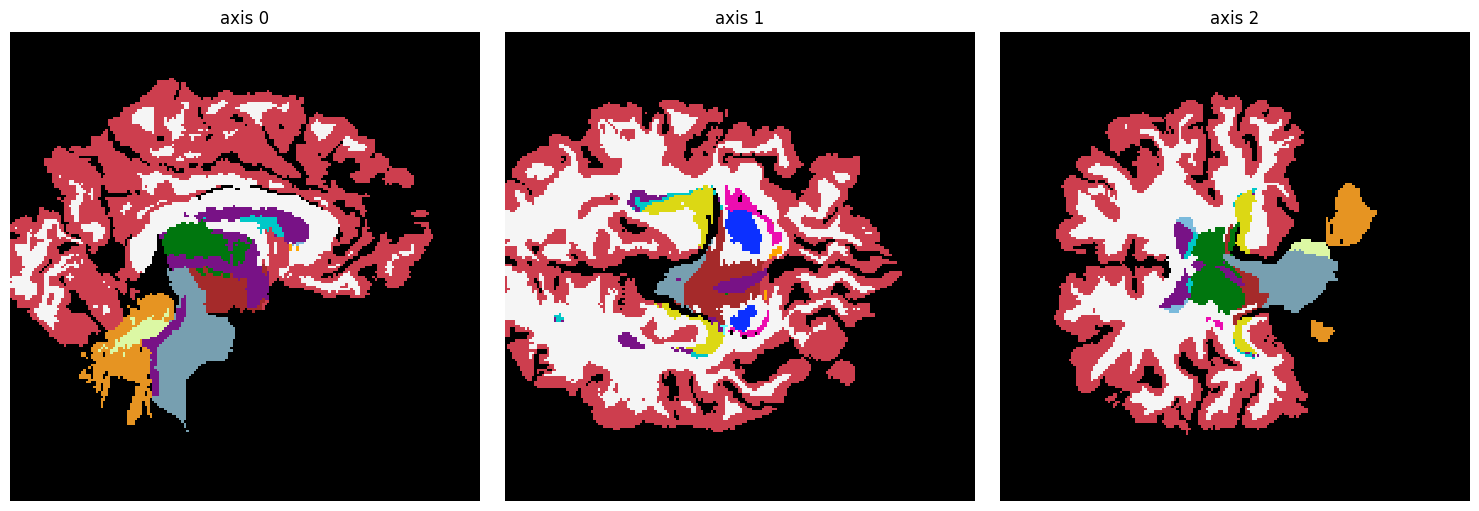

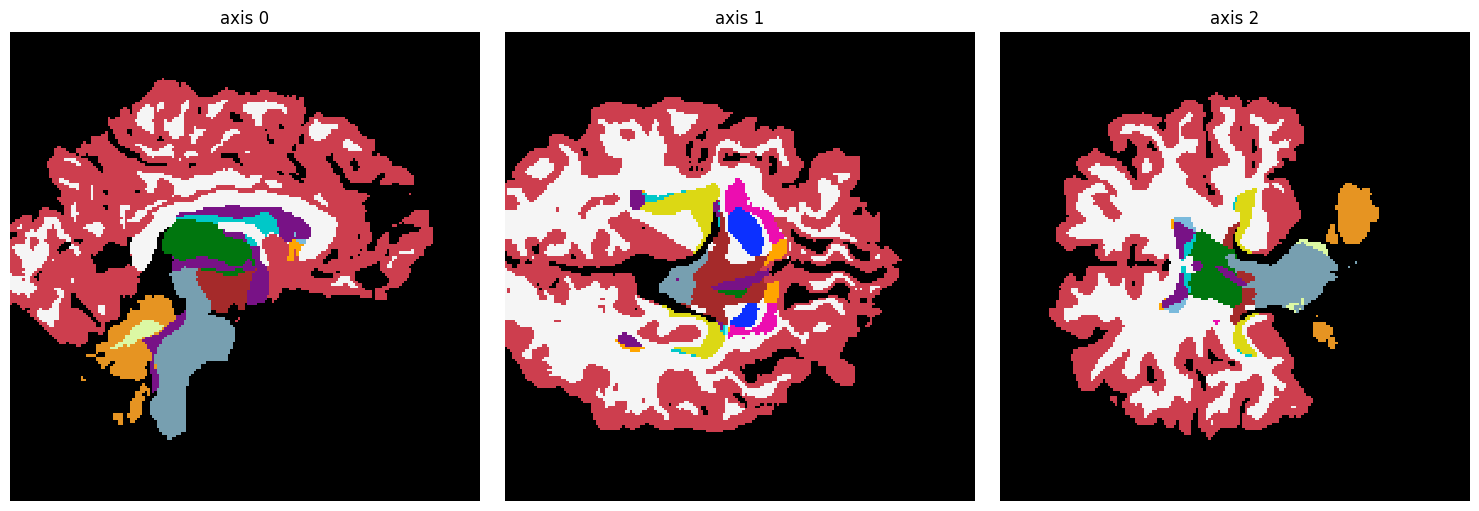

0.677912034919762


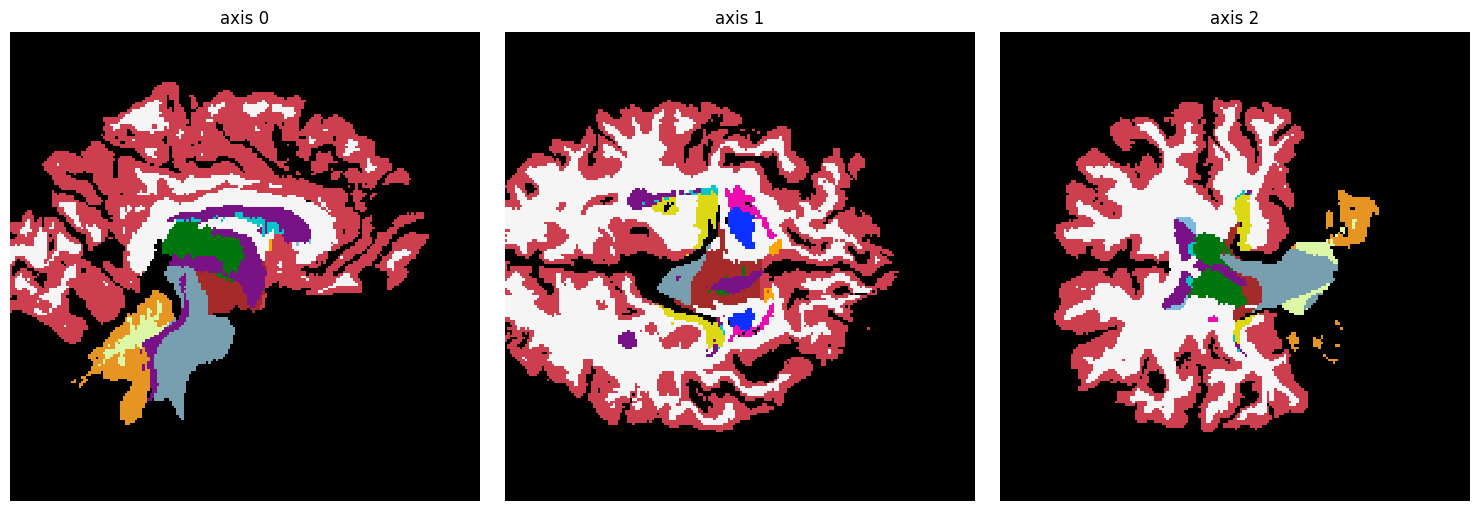

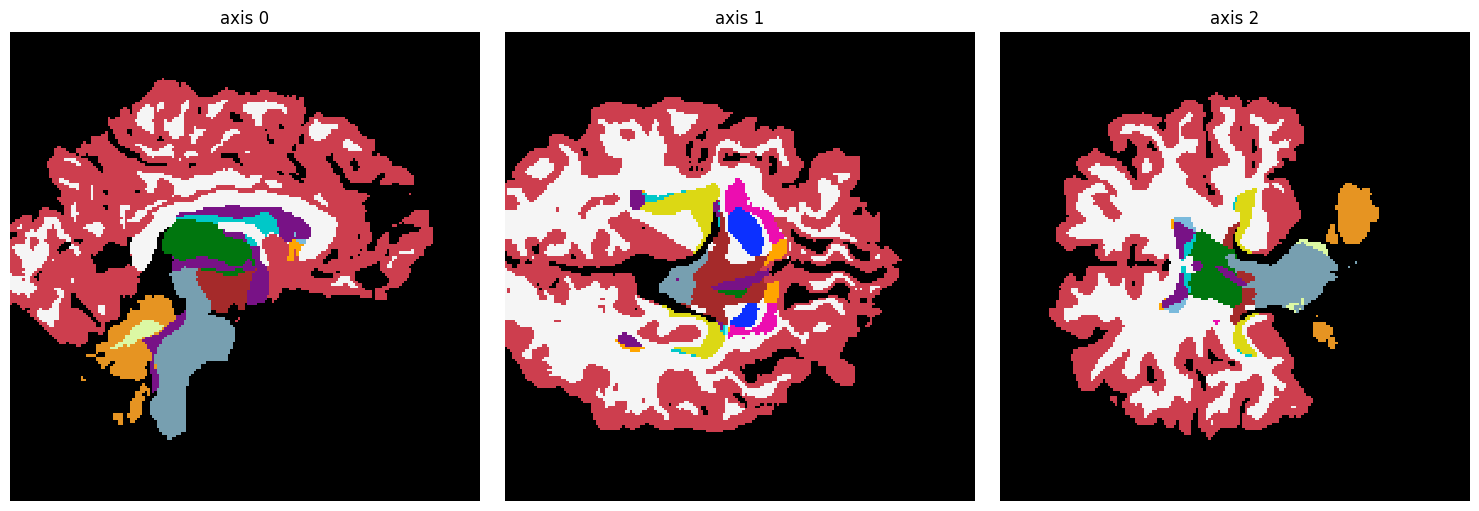

0.6888484488143014


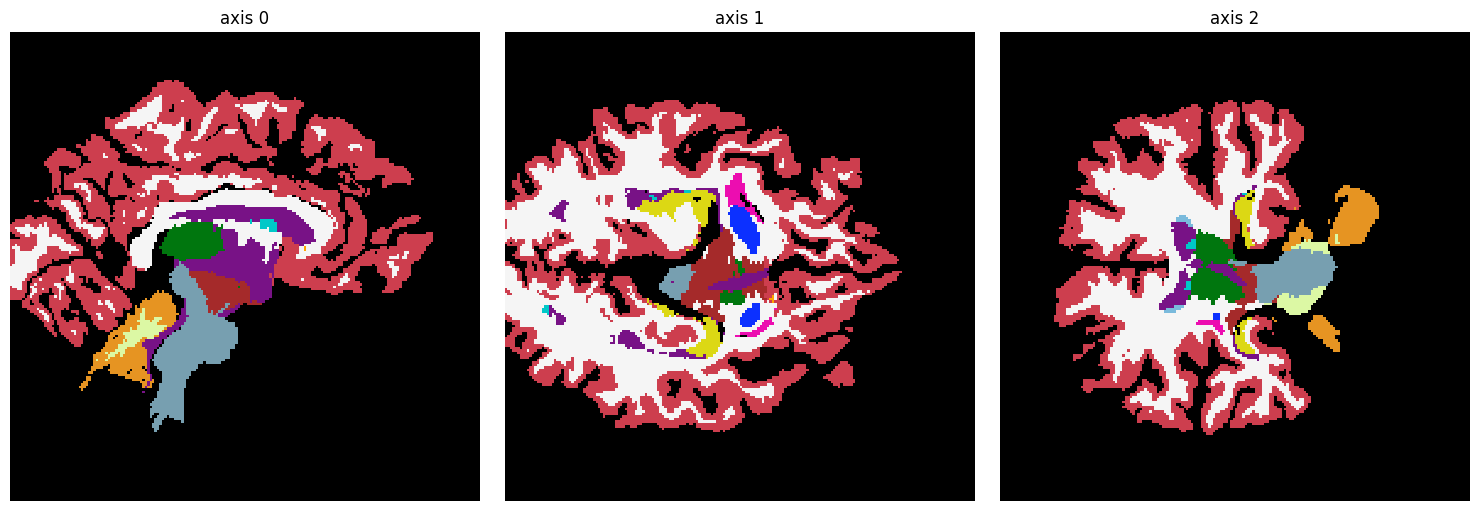

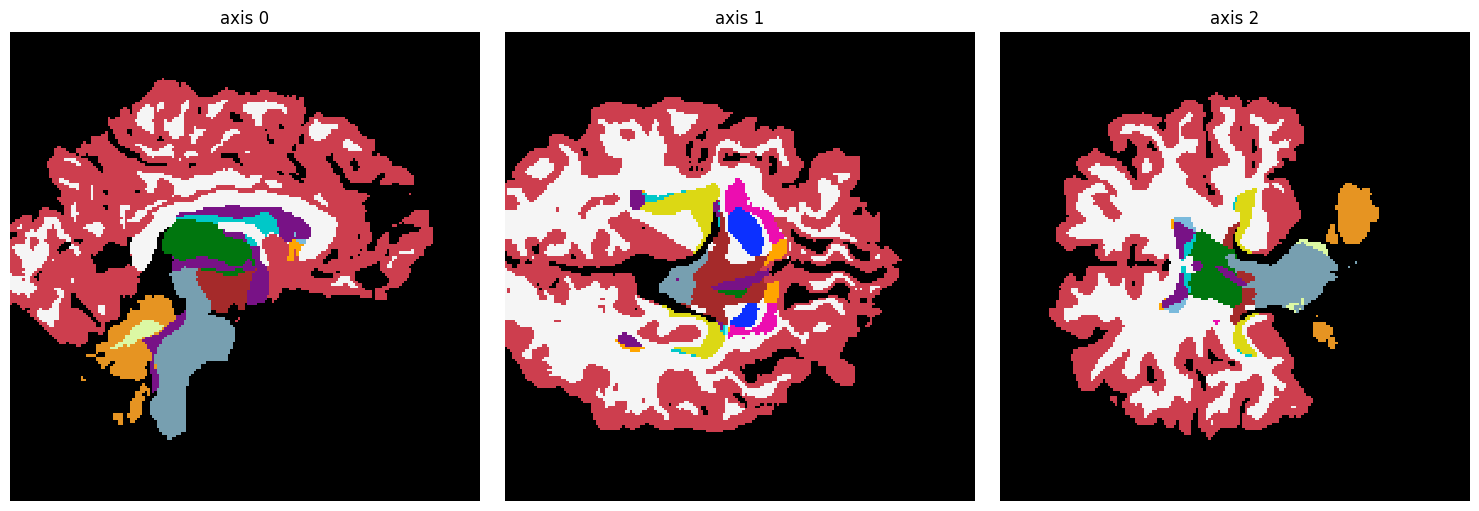

0.7566379731321765


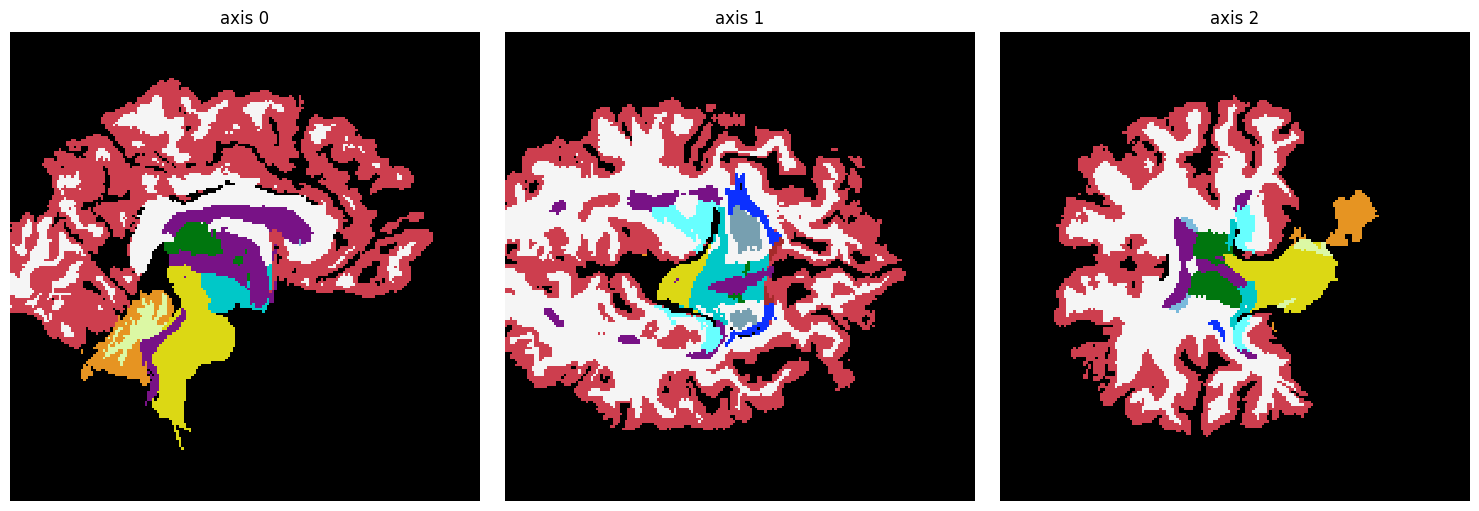

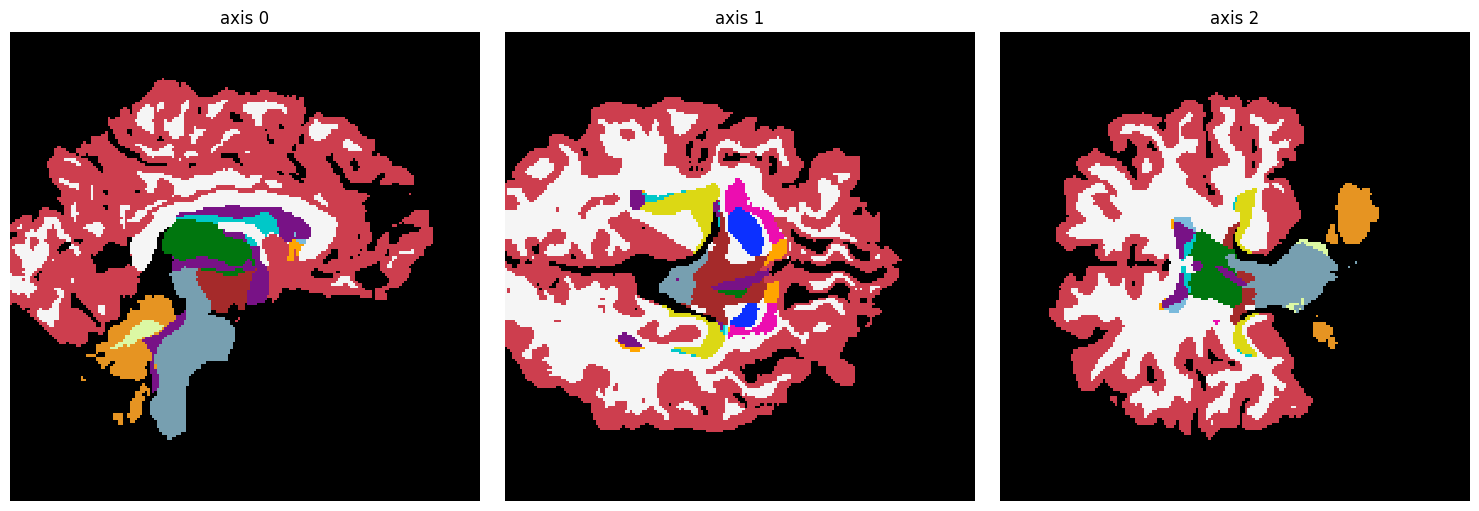

0.6888484488143014


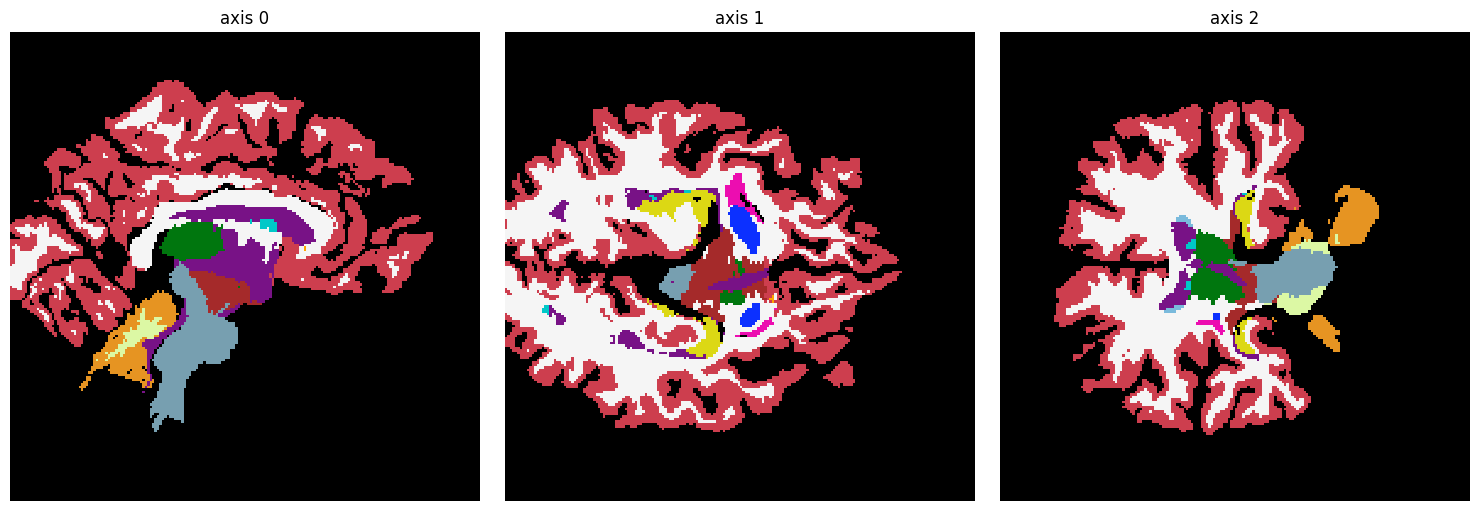

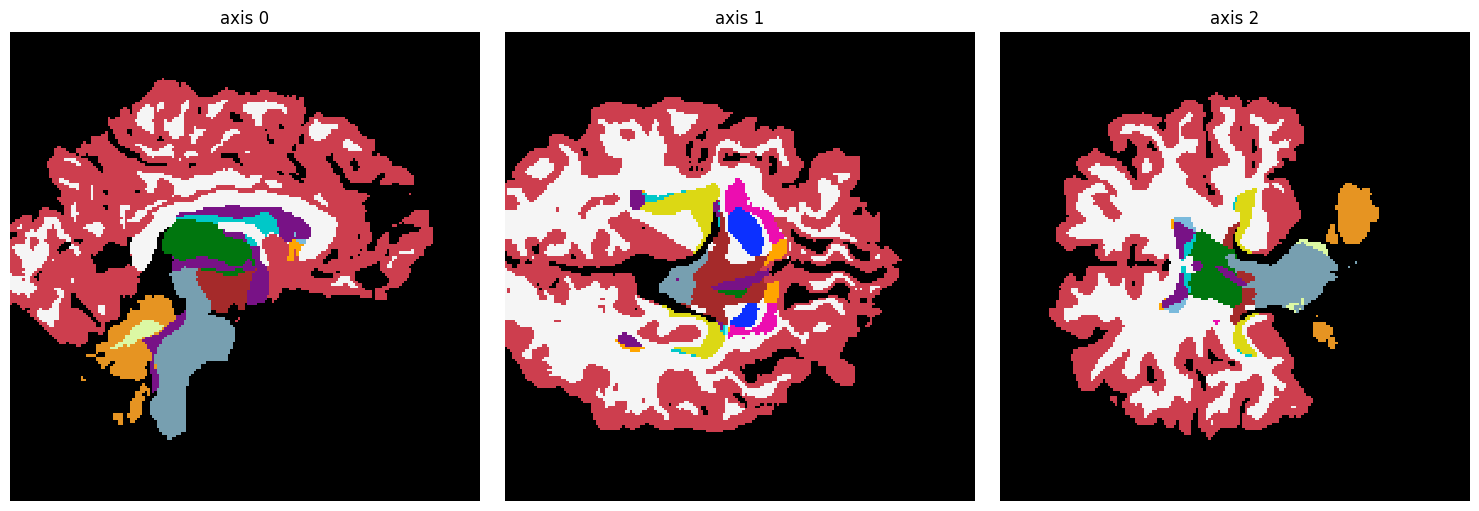

average dice: 0.7120066610949756


In [8]:
# def dice_coefficient(y_true, y_pred):
#     intersection = np.sum(y_true * y_pred)
#     union = np.sum(y_true) + np.sum(y_pred)
#     return (2.0 * intersection) / (union) 

first_slice_numbers = [100,102,77]
fs_cmap, fs_norm = make_cmap('nonlat.txt') 
dice_scores = []
for i in range(num_gen):
    t = tseg[i].astype(np.int32)
    p = pseg[i].astype(np.int32)
    dice_score = my_nonzero_hard_dice(t,p)
    dice_scores.append(dice_score)
    print(dice_score)
    ne.plot.volume3D(t, cmaps=[fs_cmap],slice_nos=first_slice_numbers)
    ne.plot.volume3D(p, cmaps=[fs_cmap],slice_nos=first_slice_numbers)
print("average dice:",np.mean(dice_scores))

In [112]:
lut_name = 'nonlat.txt'
mri_segs_recoded = [fs.label.recode(mri, mapping) for mri in mri_segs]  
lesion_label = target_lut.search('Left-Lesion')[0]
csf_label = target_lut.search('CSF')[0]

np_segs = [vol.data for vol in mri_segs_recoded]
labels_in = np.unique(np.array(np_segs)).astype(int)

In [122]:
np_segs_no_csf = [np.where(vol == csf_label, 0, vol) for vol in np_segs]


In [118]:
np.unique(mri_segs_recoded[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

In [127]:
np.unique(np_segs_no_csf[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

In [136]:
for vol in np_segs_no_csf:
    vol[vol == csf_label] = 0

In [137]:
np.unique(np_segs_no_csf[0])

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)